In [2]:
# !python -m pip install pytrends
# !python -m pip install --upgrade urllib3
# !python -m pip install --upgrade requests

In [3]:
import glob
import os
import time
from datetime import datetime

import pandas as pd
from pandas.tseries.offsets import MonthBegin, MonthEnd
import plotly.express as px
from pytrends.request import TrendReq

gt_monthly_files = glob.glob('gt_monthly_*.csv')
gt_monthly_latest = max(gt_monthly_files, key=os.path.getctime)
gt_monthly_raw = pd.read_csv(gt_monthly_latest, parse_dates=['start_date','end_date'])

gt_weekly_files = glob.glob('gt_weekly_*.csv')
gt_weekly_latest = max(gt_weekly_files, key=os.path.getctime)
gt_weekly_raw = pd.read_csv(gt_weekly_latest, parse_dates=['start_date','end_date'])

gt_daily_files = glob.glob('gt_daily_*.csv')
gt_daily_latest = max(gt_daily_files, key=os.path.getctime)
gt_daily_raw = pd.read_csv(gt_daily_latest, parse_dates=['date'])

pytrends = TrendReq(retries=8, backoff_factor=1)
# 
past_weekly_requests = set(gt_weekly_raw['pytrends_params'])
past_daily_requests = set(gt_daily_raw['pytrends_params'])

In [4]:
keyword = "inflation"

In [5]:
## makes requests ##
pytrends.build_payload([keyword], cat=0, timeframe=f'2004-01-01 {datetime.now().strftime("%Y-%m-%d")}', geo="US")
gt_monthly = pytrends.interest_over_time()

gt_monthly = gt_monthly.copy()
gt_monthly = gt_monthly.reset_index()
gt_monthly = gt_monthly.rename(columns={'date':'start_date', keyword:'index'})
gt_monthly['end_date'] = gt_monthly['start_date'] + MonthEnd(0)
gt_monthly['search_term'] = keyword
gt_monthly['pytrends_params'] = str(pytrends.token_payload)

gt_monthly.to_csv(f'gt_monthly_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

In [50]:
years = list(range(2004, datetime.now().year+1))
year_ranges = [(f'{year}-01-01 {year}-12-31') for year in years]

kw_yrc = {}
for i in set(gt_weekly_raw['search_term']):
    kw_data = gt_weekly_raw.loc[gt_weekly_raw['search_term']==i]
    
    year_ranges_completed = kw_data['pytrends_params'].str.extract(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"')[0]
    year_ranges_completed = list(set(year_ranges_completed))
    
    kw_yrc[i] = year_ranges_completed

year_ranges_to_do = [x for x in year_ranges if x not in kw_yrc[keyword]]
year_ranges_to_do.sort()

print(f'Since 2004 there are {len(year_ranges)} year ranges')
print(f'Already pulled {len(kw_yrc[keyword])} year ranges for "{keyword}"')
print(f'Need to get {len(year_ranges_to_do)} year ranges for "{keyword}"')

Since 2004 there are 22 year ranges
Already pulled 22 year ranges for "inflation"
Need to get 0 year ranges for "inflation"


In [7]:
## makes requests ##
# Weekly interest index by year since 2004
dat = []
for i in year_ranges_to_do:
    pytrends.build_payload([keyword], cat=0, timeframe=i, geo="US")

    if str(pytrends.token_payload) not in past_weekly_requests:
        weekly_us = pytrends.interest_over_time()
        weekly_us = weekly_us.reset_index()
        weekly_us = weekly_us.rename(columns={'date':'start_date', 'inflation':'index'})
        weekly_us['end_date'] = weekly_us['start_date'] + pd.Timedelta(days=6)
        weekly_us['search_term'] = keyword
        weekly_us['pytrends_params'] = str(pytrends.token_payload)
        
        dat.append(weekly_us)
    time.sleep(1)

if dat:
    weekly_us_new = pd.concat(dat)
    
    gt_weekly = pd.concat([gt_weekly_raw,weekly_us_new])
    gt_weekly = gt_weekly.drop_duplicates()
    
    gt_weekly.to_csv(f'gt_weekly_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

In [8]:
week_ranges = list(gt_weekly_raw['start_date'].astype(str)+" "+gt_weekly_raw['end_date'].astype(str))
week_ranges = list(set(week_ranges))

week_ranges_completed = gt_daily_raw['pytrends_params'].str.extract(r'"(\d{4}-\d{2}-\d{2} \d{4}-\d{2}-\d{2})"')[0]
week_ranges_completed = list(set(week_ranges_completed))

week_ranges_to_do = [x for x in week_ranges if x not in week_ranges_completed]
week_ranges_to_do.sort()

print(f'Since 2004 there are {len(week_ranges)} week ranges')
print(f'Already pulled {len(week_ranges_completed)} week ranges')
print(f'Need to get {len(week_ranges_to_do)} week ranges')

Since 2004 there are 1108 week ranges
Already pulled 1108 week ranges
Need to get 0 week ranges


In [9]:
## makes requests ##
dat = []
for idx,i in enumerate(week_ranges_to_do):
    print(i,end=" ")
    pytrends.build_payload([keyword], cat=0, timeframe=i, geo="US") # If script failings here, try going to the actual UI and 
    print('Payload built successfully')                             # completing the captia - https://trends.google.com/trends/
                                                                    # If there is no capia and the script still fails, wait a few hours
    if str(pytrends.token_payload) not in past_daily_requests:
        print("This week is new, gathering interest_over_time...")
        
        for _attempt in range(3):    # does this even make sense with higher pytrends retry numbers?
            try:
                daily_us = pytrends.interest_over_time()
                daily_us = daily_us.reset_index()
                daily_us = daily_us.rename(columns={keyword:'index'})
                daily_us['search_term'] = keyword
                daily_us['pytrends_params'] = str(pytrends.token_payload)
                dat.append(daily_us)
                print("Success!")
            except requests.exceptions.RequestException as e:
                print(f"RequestException: {e} - sleeping for 71s..")
                time.sleep(71)
                print(f'Retrying attempt {_attempt + 1}...')
            except ResponseError as e:
                print(f"ResponseError: {e} - sleeping for 71s..")
                time.sleep(71)
                print(f'Now trying attempt {_attempt + 1}...')
    time.sleep(2)

In [10]:
if dat:
    gt_daily_new = pd.concat(dat)
    
    gt_daily = pd.concat([gt_daily_raw,gt_daily_new])
    gt_daily = gt_daily.drop_duplicates()
    
    gt_daily.to_csv(f'gt_daily_{datetime.today().strftime("%Y%m%d")}.csv', index=False)

In [26]:
index_of_week = gt_weekly_raw[['start_date','index']]
index_of_week = index_of_week.rename(columns={'start_date':'week_start_sun','index':'index_of_week'})

index_of_month = gt_monthly_raw.rename(columns={'start_date':'month_start','index':'index_of_month'})
index_of_month['month_end'] = index_of_month['month_start'] + MonthEnd(0)
index_of_month = index_of_month[['month_start','index_of_month']]

index_of_day = gt_daily_raw.copy()
index_of_day['day_of_week'] = index_of_day['date'].dt.day_name()
index_of_day['week_start_sun'] = index_of_day["date"].dt.to_period("W-SAT").dt.start_time
index_of_day['month_start'] = index_of_day["date"] - MonthBegin(1)

gt_adjusted = index_of_day.merge(index_of_week, how='left', on='week_start_sun')
gt_adjusted = gt_adjusted.merge(index_of_month, how='left', on='month_start')

gt_adjusted['index'] = gt_adjusted['index']*gt_adjusted['index_of_week']/100
gt_adjusted['index'] = gt_adjusted['index']*gt_adjusted['index_of_month']/100
gt_adjusted = gt_adjusted[['date','day_of_week','search_term','index']]

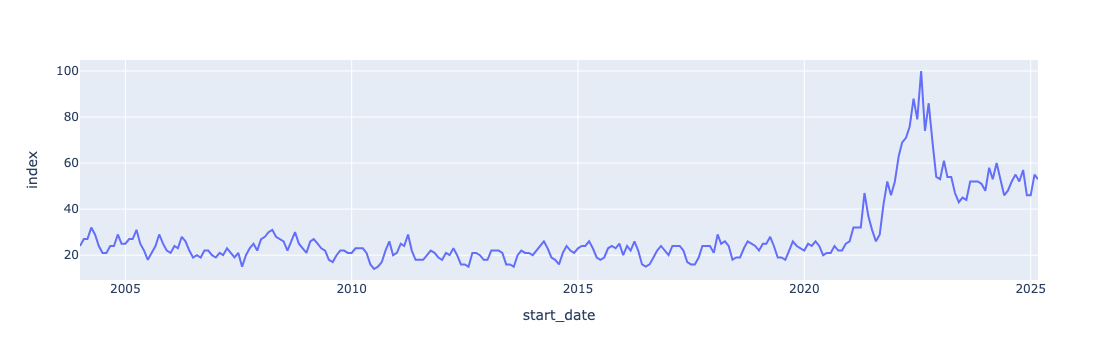

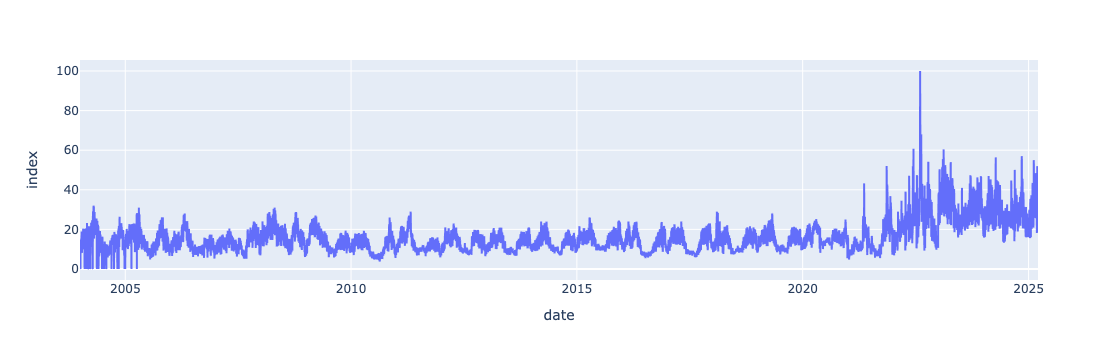

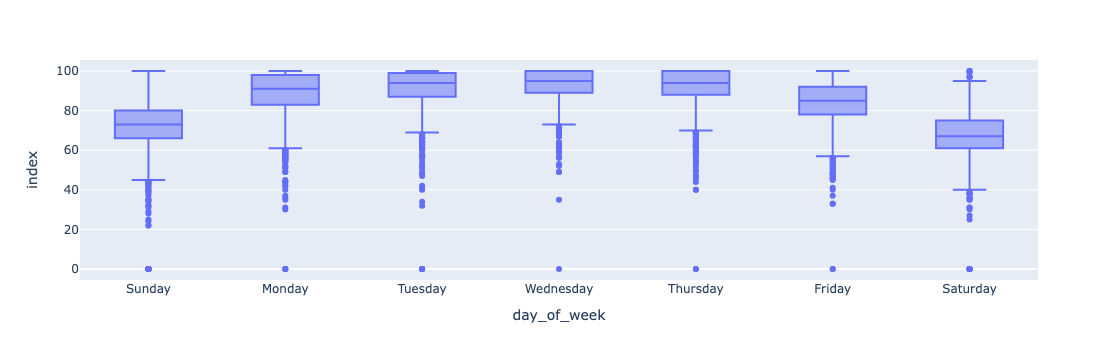

In [28]:
fig1 = px.line(gt_monthly_raw.sort_values(by='start_date'), x="start_date", y="index")
fig2 = px.line(gt_adjusted.sort_values(by='date'), x="date", y="index")
fig3 = px.box(index_of_day, x="day_of_week", y="index")
fig3.update_xaxes(categoryorder='array', categoryarray= ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
fig1.show()
fig2.show()
fig3.show()